In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

In [2]:
PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
import functools

import jax
import jax.numpy as jnp


###########
@functools.partial(
    jnp.vectorize,
    signature="(m)->()",
    excluded=(
        1,
        2,
        3,
        4,
        5,
        6,
    ),
)
def gausssian_mixture_vectorize_old(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    variance,
    outlier_prob: float,
    outlier_volume: float,
    filter_size: int,
):
    distances = observed_xyz[ij[0], ij[1], :3] - jax.lax.dynamic_slice(
        rendered_xyz_padded,
        (ij[0], ij[1], 0),
        (2 * filter_size + 1, 2 * filter_size + 1, 3),
    )
    probabilities = jax.scipy.stats.norm.logpdf(
        distances, loc=0.0, scale=jnp.sqrt(variance)
    ).sum(-1) - jnp.log(observed_xyz.shape[0] * observed_xyz.shape[1])
    # return jnp.logaddexp(
    #     probabilities.max() + jnp.log(1.0 - outlier_prob),
    #     jnp.log(outlier_prob) - jnp.log(outlier_volume),
    # )
    return {
        "inlier_score": probabilities.max() + jnp.log(1.0 - outlier_prob),
        "outlier_score": jnp.log(outlier_prob) - jnp.log(outlier_volume),
    }


def threedp3_likelihood_per_pixel_old(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size,
):
    rendered_xyz_padded = jax.lax.pad(
        rendered_xyz,
        -100.0,
        (
            (
                filter_size,
                filter_size,
                0,
            ),
            (
                filter_size,
                filter_size,
                0,
            ),
            (
                0,
                0,
                0,
            ),
        ),
    )
    jj, ii = jnp.meshgrid(
        jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0])
    )
    indices = jnp.stack([ii, jj], axis=-1)
    log_probabilities = gausssian_mixture_vectorize_old(
        indices,
        observed_xyz,
        rendered_xyz_padded,
        variance,
        outlier_prob,
        outlier_volume,
        filter_size,
    )
    return log_probabilities


def threedp3_likelihood_old(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    focal_length,
    filter_size,
):
    log_probabilities_per_pixel = threedp3_likelihood_per_pixel_old(
        observed_xyz, rendered_xyz, variance, outlier_prob, outlier_volume, filter_size
    )
    return log_probabilities_per_pixel  # .sum()


def threedp3_likelihood(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = (distances < variance / 2) / variance
    average_probability = probabilities_per_pixel.mean()
    return average_probability

In [4]:
likelihood = jax.vmap(
    threedp3_likelihood_old, in_axes=(None, 0, None, None, None, None, None)
)

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


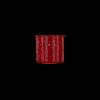

In [5]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    100,
    100,
    200.0,
    200.0,
    50.0,
    50.0,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.6, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 0  # 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_img, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
b3d.get_rgb_pil_image(gt_img)

In [6]:
delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)


cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

test_poses_batches = test_poses.split(100)

In [7]:
from b3d.camera import unproject_depth

In [8]:
gt_depth_image = unproject_depth(
    gt_depth,
    (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
)

In [9]:
scores = []
inlier_scores = []
undecided_scores = []
outlier_scores = []

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )

    unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
    rendered_images = unproject_depth_vec(
        depth_ims,
        (
            100,
            100,
            200.0,
            200.0,
            50.0,
            50.0,
            0.01,
            10.0,
        ),
    )
    # 1.0 far plane is fixed, value is used for 'unexplained' pixels

    # variance,outlier_prob,outlier_volume,focal_length,filter_size,
    # 0.05, 0.1, 10**3, 0.1, 3
    scores_batch = likelihood(gt_depth_image, rendered_images, 0.005, 0.1, 10, 0.1, 3)
    scores_frame = jnp.logaddexp(
        scores_batch["inlier_score"], scores_batch["outlier_score"]
    )
    scores.append(scores_frame.sum(axis=(1, 2)))

    # modify to get inlier/outlier performance back in

    # inlier_scores.append(scores_dict['inlier_score'])
    # undecided_scores.append(scores_dict['undecided_score'])
    # outlier_scores.append(scores_dict['outlier_score'])

scores = jnp.concatenate(scores)
samples = jax.random.categorical(key, scores, shape=(50,))

In [21]:
scores_batch["inlier_score"].shape

(682, 100, 100)

In [10]:
gt_depth_image.shape

(100, 100, 3)

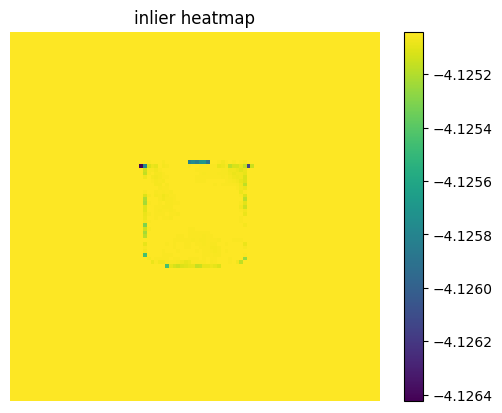

In [11]:
original_view_im, original_view_depth = renderer.render_attribute(
    (camera_pose.inv() @ test_poses[jnp.argsort(scores)[::-1][2]])[None, ...],  #
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

# generate inlier/outlier maps

xyz = unproject_depth(
    original_view_depth,
    (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
)
pixel_scores = likelihood(gt_depth_image, xyz[None, ...], 0.005, 0.1, 10, None, 3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Masks (inlier, teleport outlier, nonteleport outlier)')
# ax1.imshow(pixel_scores[0])

plt.imshow(pixel_scores["inlier_score"][0])
plt.axis("off")
plt.title("inlier heatmap")
plt.colorbar()

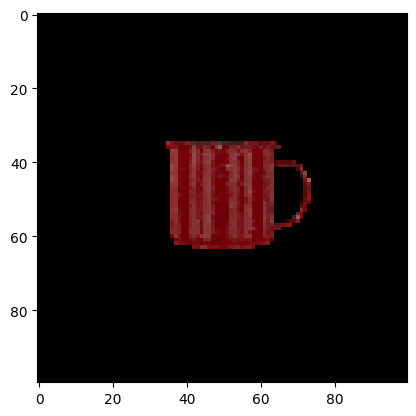

In [12]:
plt.imshow(original_view_im)

In [13]:
# weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)

In [14]:
samples = jax.random.categorical(key, scores, shape=(50,))
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (jnp.max(delta_cps[samples], axis=0) - jnp.min(delta_cps[samples], axis=0))[2]
)

print("Sampled Angle Range:", samples_deg_range)
pix_scores = scores

GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 334.2857


In [15]:
alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

original_view_images, original_view_depths = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

xyzs = unproject_depth_vec(
    original_view_depths,
    (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
)
pixel_scores = likelihood(gt_depth_image, xyzs, 0.005, 0.1, 10, None, 3)

for t in range(len(alternate_view_images)):
    rr.set_time_sequence("time", t)
    rr.log(f"samples/alternate_view", rr.Image(alternate_view_images[t]))
    # rr.log(f"samples/original_view", rr.Image(original_view_images[t]))
    # rr.log(f"samples/overlay_mask", rr.Image((gt_img.sum(axis=2)>0)*1.0))
    rr.log(
        f"samples/original_view",
        rr.Image(
            (
                original_view_images[t] * 0.7
                + (gt_img.sum(axis=2) > 0)[..., None] * jnp.ones(3)[None, None, :] * 0.3
            )
        ),
    )

    pixel_im = pixel_scores["inlier_score"][t]
    cmap = matplotlib.colormaps["inferno"]
    norm = matplotlib.colors.Normalize(vmin=pixel_im.min(), vmax=pixel_im.max())
    rr.log(f"samples/heatmap", rr.Image(cmap(norm(pixel_im))))

In [16]:
# b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(original_view_image*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
#                               for original_view_image in original_view_images], 'gaussian_posterior_coarse_samples.gif'
# )

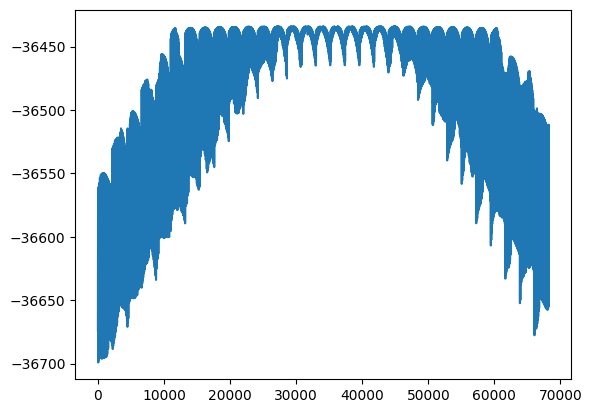

In [17]:
plt.plot(scores)

In [18]:
# samples = jax.random.categorical(key, jnp.zeros(test_poses.shape), shape=(50,))

# alternate_view_images, alternate_view_depths = renderer.render_attribute_many(
#     (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
#     object_library.vertices,
#     object_library.faces,
#     object_library.ranges[jnp.array([0])],
#     object_library.attributes,
# )

# original_view_images, original_view_depths = renderer.render_attribute_many(
#     (camera_pose.inv() @ test_poses[samples])[:, None, ...],
#     object_library.vertices,
#     object_library.faces,
#     object_library.ranges[jnp.array([0])],
#     object_library.attributes,
# )

# for t in range(len(alternate_view_images)):
#     rr.set_time_sequence("time", t)
#     rr.log(f"random/alternate_view", rr.Image(alternate_view_images[t]))
#     rr.log(f"random/original_view", rr.Image(original_view_images[t]))
#     # rr.log(f"random/alternate_view_depths", rr.DepthImage(alternate_view_depths[t]))
#     # rr.log(f"random/original_view_depths", rr.DepthImage(original_view_depths[t]))

In [19]:
# b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(original_view_image*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
#                               for original_view_image in original_view_images], 'gaussian_random_coarse_samples.gif'
# )